# Rating Alignment via Text Classification

This notebook aims to correct potential misalignments between user-generated textual reviews and their associated star ratings in the dataset. Using `clean_text` and `doRecommend`, we train a multi-class classification model to predict the most likely rating on a 1-to-5 scale.

The resulting column, `aligned_rating`, represents a machine-learned approximation of what the rating *should* be based on the sentiment and recommendation intent found in the review content.

This approach allows us to:
- Flag inconsistent entries (e.g., positive text + low rating)
- Improve training labels for downstream sentiment models
- Understand rating bias in customer feedback


#### Import Librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

ModuleNotFoundError: No module named 'lightgbm'

#### Load dataset

In [ ]:
df = pd.read_csv("data/cleaned_amazon_reviews_final.csv")

# Filter necessary columns and drop NA
df = df[['clean_text', 'doRecommend', 'rating']].dropna()

# Convert doRecommend from string to binary (if needed)
df['doRecommend'] = df['doRecommend'].astype(str).str.lower().map({'true': 1, 'false': 0, '1': 1, '0': 0})

# Drop rows with unknown doRecommend
df = df[df['doRecommend'].isin([0, 1])]

# Keep only ratings in 1-5 range
df = df[df['rating'].isin([1, 2, 3, 4, 5])]

#### Step 2: Prepare train/test sets

In [ ]:

X = df[['clean_text', 'doRecommend']]

# Necessary mapping to use XGBoost
rating_to_class = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
class_to_rating = {v: k for k, v in rating_to_class.items()}
y = df['rating'].map(rating_to_class).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

#### Step 3: Create preprocessing pipeline

In [ ]:
# Custom transformer to extract a single column
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.column_name]

# Create transformers
text_transformer = Pipeline([
    ('extract_text', ColumnExtractor('clean_text')),
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)))
])

meta_transformer = Pipeline([
    ('extract_meta', ColumnExtractor('doRecommend')),
    ('reshape', FunctionTransformer(lambda x: x.values.reshape(-1, 1))),
    ('scaler', StandardScaler())
])

# Combine text and metadata features
preprocessor = FeatureUnion([
    ('text', text_transformer),
    ('meta', meta_transformer)
])

#### Step 4: Define classifiers and hyperparameters

In [ ]:
# Pipelines with class weighting enabled to handle class imbalance
pipelines = {
    'logreg': Pipeline([
        ('features', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))  # Automatically adjusts weights per class frequency
    ]),
    'rf': Pipeline([
        ('features', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced'))  # Penalizes majority class dominance
    ]),
    'svc': Pipeline([
        ('features', preprocessor),
        ('clf', SVC(class_weight='balanced'))  # Improves recall on under-represented classes
    ]),
    'xgb': Pipeline([
        ('features', preprocessor),
        ('clf', XGBClassifier(scale_pos_weight=1))  # No-op for multiclass but placeholder for binary adjustment
    ]),
    'lgbm': Pipeline([
        ('features', preprocessor),
        ('clf', LGBMClassifier(class_weight='balanced'))  # Applies sample weighting internally
    ])
}

# GridSearchCV hyperparameters to tune for each model
params = {
    'logreg': {
        'clf__C': [0.1, 1, 10]  # Inverse regularization strength
    },
    'rf': {
        'clf__n_estimators': [100, 200],  # Number of trees
        'clf__max_depth': [10, 20]        # Max depth per tree
    },
    'svc': {
        'clf__C': [1, 10],                # Regularization
        'clf__kernel': ['linear', 'rbf']  # Kernel type
    },
    'xgb': {
        'clf__n_estimators': [100],       # Number of boosting rounds
        'clf__max_depth': [6]             # Tree depth
    },
    'lgbm': {
        'clf__n_estimators': [100],       # Number of boosting iterations
        'clf__max_depth': [6]             # Max tree depth
    }
}


#### Step 5: GridSearchCV across all models

In [ ]:
best_models = {}
results = {}
best_score = 0
best_model_name = None

for name, pipeline in pipelines.items():
    print(f"\n🔍 Tuning {name.upper()}...")
    grid = GridSearchCV(pipeline, param_grid=params[name], cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Save best model and accuracy
    best_models[name] = grid.best_estimator_
    acc = grid.best_score_
    results[name] = {
        'accuracy': acc,
        'params': grid.best_params_,
        'report': classification_report(y_test, grid.predict(X_test), output_dict=True)
    }

    # Track best model
    if acc > best_score:
        best_score = acc
        best_model_name = name

    print(f"✅ Best accuracy for {name}: {acc:.4f}")
    print("🧾 Classification Report:")
    print(classification_report(y_test, grid.predict(X_test)))



🔍 Tuning LOGREG...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
✅ Best accuracy for logreg: 0.6806
🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.58      0.37        24
           1       0.27      0.37      0.31        27
           2       0.58      0.17      0.26        84
           3       0.45      0.54      0.49       530
           4       0.83      0.77      0.80      1465

    accuracy                           0.69      2130
   macro avg       0.48      0.49      0.45      2130
weighted avg       0.71      0.69      0.69      2130


🔍 Tuning RF...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best accuracy for rf: 0.6998
🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.33      0.43        24
           1       0.29      0.15      0.20        27
           2       0.52      0.50      0.51        84
           3       0.47

c:\Users\jeand\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:58:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best accuracy for xgb: 0.7147
🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.38      0.39        24
           1       0.24      0.22      0.23        27
           2       0.48      0.30      0.37        84
           3       0.53      0.26      0.35       530
           4       0.77      0.93      0.85      1465

    accuracy                           0.73      2130
   macro avg       0.49      0.42      0.44      2130
weighted avg       0.69      0.73      0.69      2130


🔍 Tuning LGBM...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44957
[LightGBM] [Info] Number of data points in the train set: 8517, number of used features: 1365
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training

#### Step 6: Select best model and predict

In [ ]:
# Pick the best model manually or by accuracy
print(f"\n🏆 Best performing model: {best_model_name.upper()} with accuracy = {best_score:.4f}")
best_model = best_models[best_model_name] # Or change manualy 'logreg' / 'rf' / 'svc' / 'xgb' / 'lgbm'


🏆 Best performing model: XGB with accuracy = 0.7147


In [ ]:
# Predict aligned ratings on the full dataset
df['aligned_rating'] = best_model.predict(df[['clean_text', 'doRecommend']])
df['aligned_rating'] = df['aligned_rating'].map(class_to_rating)  # Map back if needed

#### Step 7: Error analysis and visualization

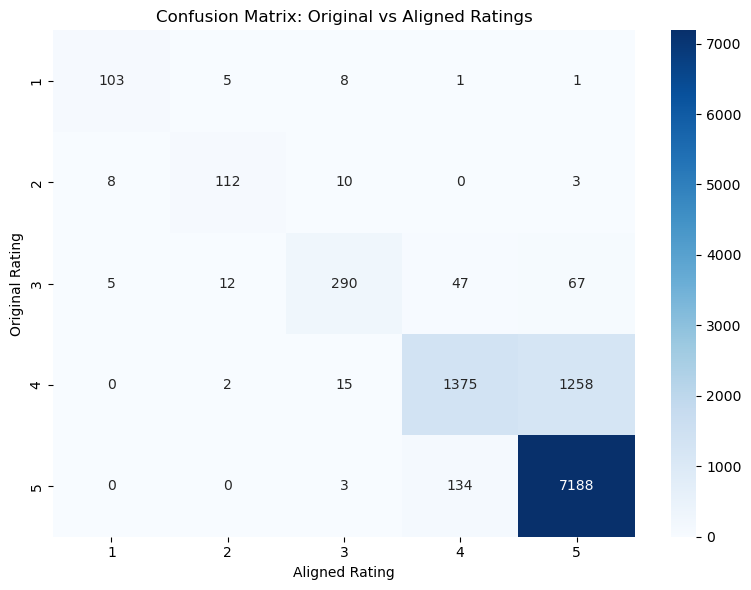


🔍 Sample mismatches:
                                              clean_text  rating  \
3726   nice tablet good pictur work well great variet...       5   
2381   eas use bought grand daughter xma sinc year ol...       4   
18625            great price bought coupl kid xmass love       4   
1258      need advanc like alexa need interact like suri       3   
1847   great tablet kid mainli bought daughter could ...       4   

       aligned_rating  
3726                4  
2381                5  
18625               5  
1258                5  
1847                5  


In [ ]:
conf_mat = confusion_matrix(df['rating'], df['aligned_rating'], labels=[1, 2, 3, 4, 5])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Aligned Rating")
plt.ylabel("Original Rating")
plt.title("Confusion Matrix: Original vs Aligned Ratings")
plt.tight_layout()
plt.show()




#### Export result

In [ ]:
# df.to_csv("data/amazon_reviews_with_predicted_rating.csv", index=False)